In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [2]:
DIRECTORY = 'drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_06/'

## Семинар 6 "Segmentation"

ФИО: __Иванов Максим Юрьевич__

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 апреля 2019). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [3]:
!pip install imagecodecs-lite

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch as t
import torch
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io
import skimage.transform
import PIL
import imageio
from IPython.display import clear_output


TRAIN_PATH = DIRECTORY + 'train.pth'
TEST_PATH = DIRECTORY + 'test.pth'
%matplotlib inline

In [5]:
def print_memory_info(device=None):
    print(print(torch.cuda.memory_summary(device=device, abbreviated=False)))

### Загрузка и обработка данных

In [6]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process(DIRECTORY + 'datasets/test/images/')
t.save(test, TEST_PATH)
train_data = process(DIRECTORY + 'datasets/train/images', DIRECTORY + "datasets/train/1st_manual/")

In [7]:
class Dataset():
    def __init__(self, data, source_transform, target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)

In [8]:
image_size = 512

s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((image_size, image_size)),
    tsf.ToTensor(),
    tsf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((image_size, image_size),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [9]:
dataset = Dataset(train_data, s_trans, t_trans)

In [10]:
train_dataset = [dataset[i] for i in range (0, 20)]

In [11]:
s_rot_trans = lambda angle: tsf.Compose([
    tsf.ToPILImage(),
    tsf.Lambda(lambda x: tsf.functional.affine(x, angle,
        translate=(0, 0), scale=1, shear=False)),
    tsf.Resize((image_size, image_size)),
    tsf.ToTensor(),
    tsf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

t_rot_trans = lambda angle: tsf.Compose([
    tsf.ToPILImage(),
    tsf.Lambda(lambda x: tsf.functional.affine(x, angle,
        translate=(0, 0), scale=1, shear=False)),
    tsf.Resize((image_size, image_size), interpolation=PIL.Image.NEAREST),
    tsf.ToTensor()
])

In [12]:
for angle in tqdm(range(10, 360, 10)):
    r_data = Dataset(train_data, s_rot_trans(angle), t_rot_trans(angle))
    for i in range(0, len(r_data)):
        train_dataset.append(r_data[i])
print(len(train_dataset))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "



720


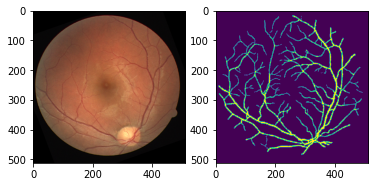

In [13]:
img,mask = train_dataset[156]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy() * 0.5 + 0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [14]:
train_loader = t.utils.data.DataLoader(train_dataset, num_workers=2, batch_size=4, shuffle=True)

In [15]:
# def get_loaders(full_dataset, split_size=0.9):
#     train_size = int(split_size * len(full_dataset))
#     valid_size = len(full_dataset) - train_size
#     train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

#     train_loader = t.utils.data.DataLoader(train_dataset, num_workers=2, batch_size=4, shuffle=True)
#     valid_loader = t.utils.data.DataLoader(valid_dataset, num_workers=2, batch_size=4, shuffle=True)

#     return train_loader, valid_loader

In [16]:
# from functools import partial

# get_loaders_func = partial(get_loaders, full_dataset=train_dataset)

### Модели

In [17]:
# sub-parts of the U-Net model

from torch import nn
import torch.nn.functional as F


class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.sigmoid(x)
        return x

In [18]:
# Попробуйте использовать различные функции потерь.
class SoftDiceLoss:
    def __call__(self, inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1) + 1) / (m1.sum(1) + m2.sum(1) + 1)
        score = 1 - score.sum()/num
        return score

In [30]:
def _epoch(network, loss, loader,
           backward=True,
           optimizer=None,
           device='cpu',
           ravel_init=False):
    losses = []
    accuracies = []
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        if ravel_init:
            X = X.view(X.size(0), -1)
        network.zero_grad()
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.cpu().item())
        if backward:
            loss_batch.backward()
            optimizer.step()
        prediction = prediction.max(1)[1]
        accuracies.append((prediction == y).cpu().float().numpy().mean())
    return losses, accuracies


def train(network, train_loader=None, test_loader=None, epochs=10, 
          learning_rate=1e-3, plot=True, verbose=True, loss=None, 
          optimizer=None, clear_data=True, get_loaders_func=None,
          ravel_init=False, device='cpu', tolerate_keyboard_interrupt=True):
    loss = loss() if loss else nn.NLLLoss()
    optimizer = optimizer(network.parameters(), learning_rate) if optimizer else torch.optim.Adam(network.parameters(), lr=learning_rate)
    if train_loader is None and get_loaders_func is None:
        raise RuntimeError("No train_loader")

    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network = network.to(device)
    try:
        for epoch in range(epochs):
            if get_loaders_func:
                train_loader, test_loader = get_loaders_func()
            if train_loader:
                network.train()
                losses, accuracies = _epoch(network,
                                            loss,
                                            train_loader,
                                            True,
                                            optimizer,
                                            device,
                                            ravel_init)
                train_loss_epochs.append(np.mean(losses))
                train_accuracy_epochs.append(np.mean(accuracies))

            if test_loader:
                network.eval()
                losses, accuracies = _epoch(network,
                                            loss,
                                            test_loader,
                                            False,
                                            optimizer,
                                            device,
                                            ravel_init)

                test_loss_epochs.append(np.mean(losses))
                test_accuracy_epochs.append(np.mean(accuracies))
            if verbose:
                if clear_data:
                    clear_output(True)
                if test_loader:
                    print('Epoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
                else:
                    print('Epoch {0}... (Train) Loss: {1:.3f}\tAccuracy: {2:.3f}'.format(
                            epoch, train_loss_epochs[-1], train_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                if test_loader:
                    plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                if test_loader:
                    plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

### Обучение

Epoch 9... (Train) Loss: 0.191	Accuracy: 0.914


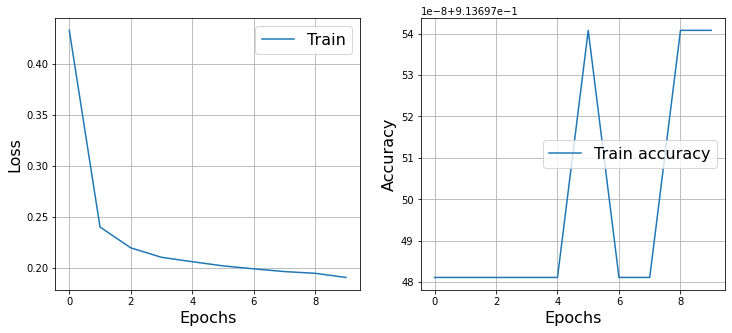

CPU times: user 15min 26s, sys: 11min 32s, total: 26min 59s
Wall time: 27min 5s


In [31]:
%%time
network = UNet(3, 1)
train(network, loss=SoftDiceLoss, train_loader=train_loader, device='cuda')

In [32]:
t.save(network, DIRECTORY + 'unet.pth.tar')

### Тест

In [33]:
class TestDataset():
    def __init__(self,path, source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset, batch_size=1)

In [34]:
# !zip -r result.zip result

In [35]:
def save_prediction(network):
    network = network.eval()
    for ex_id, data in enumerate(testdataloader):
        data = t.autograd.Variable(data, volatile=True)
        if torch.cuda.is_available():
            data = data.cuda()
        o = network(data)
        
        source_image = io.imread(DIRECTORY + "datasets/test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
        tm = o[0][0].data.cpu().numpy()
        tm = skimage.transform.resize(tm, source_image.shape[:-1])
        tm = (tm > 0.5).astype(int)
        
        imageio.imwrite(DIRECTORY + "datasets/test/result/%s.png" % (ex_id + 1), tm)

In [36]:
save_prediction(network)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


In [37]:
!zip -r result.zip drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_06/datasets/test/result

updating: drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_06/datasets/test/result/ (stored 0%)
updating: drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_06/datasets/test/result/1.png (deflated 1%)
updating: drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_06/datasets/test/result/2.png (deflated 1%)
updating: drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_06/datasets/test/result/3.png (deflated 1%)
updating: drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_06/datasets/test/result/4.png (deflated 1%)
updating: drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_06/datasets/test/result/5.png (deflated 1%)
updating: drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_06/datasets/test/result/6.png (deflated 1%)
updating: drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_06/datasets/test/result/7.png (deflated 1%)
updating: drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_06/datasets/test/result/8.png (deflated 1%)
updating: drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_06/datasets/test/result/9.png (deflated 1

In [38]:
# tm = o[0][0].data.cpu().numpy()
# plt.subplot(121)
# plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
# plt.subplot(122)
# plt.imshow(tm)

Для начала я решил увеличить размер картинки до 512*512 и попробовать сделать предсказание на сети UNet и с данным нам лоссом. Результат - 0.7246.

Далее было решено применить аугментации, а именно - повороты на 10, 20 итд градусов. Теперь вместо 20 у меня было 720 картинок для трейна и результат улучшился - 0.8064.

Логин на лидерборде __maximus3__